### Read results from csv files and visualize them:

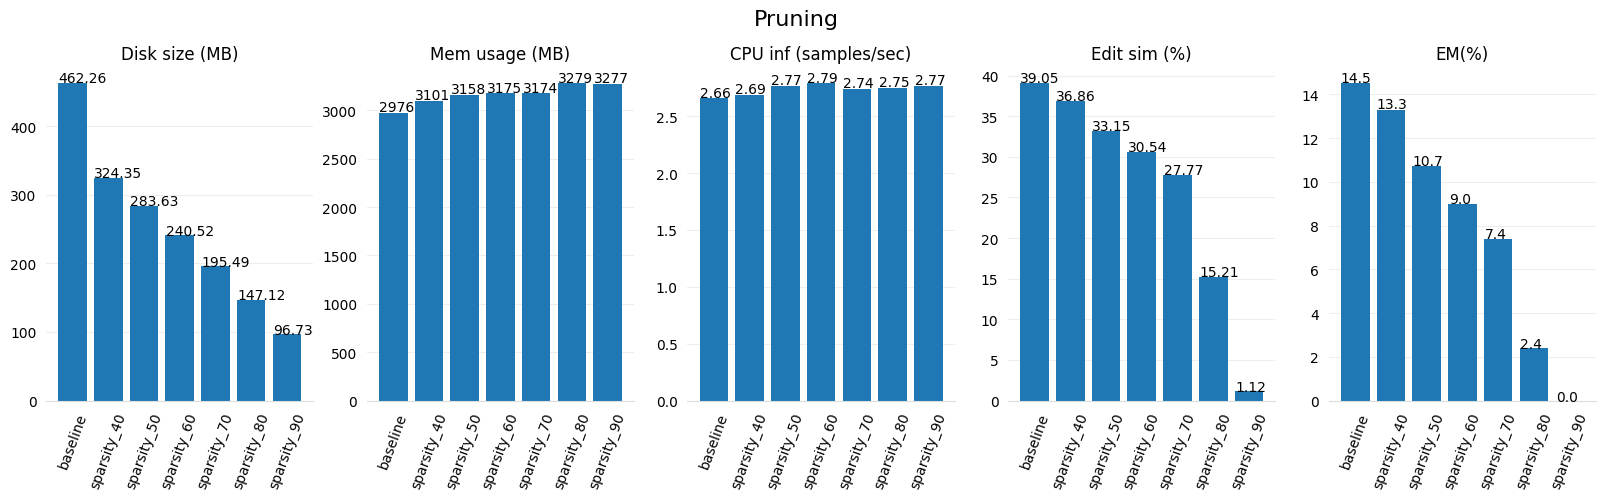

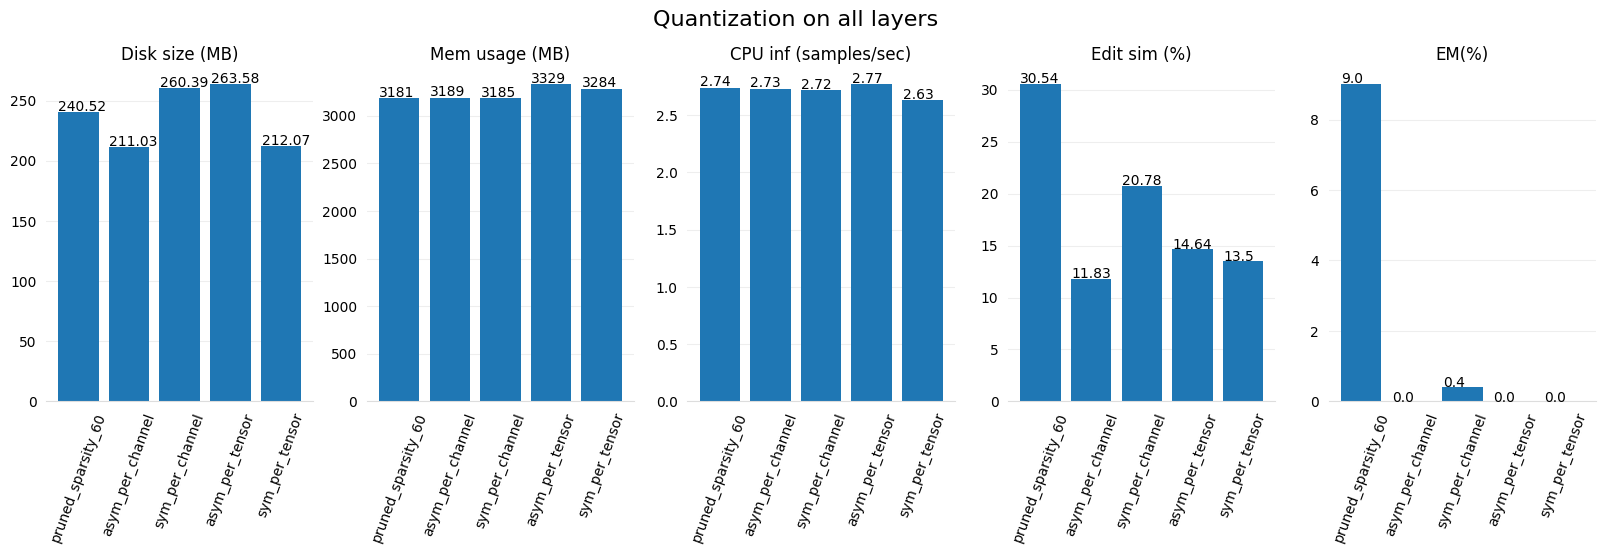

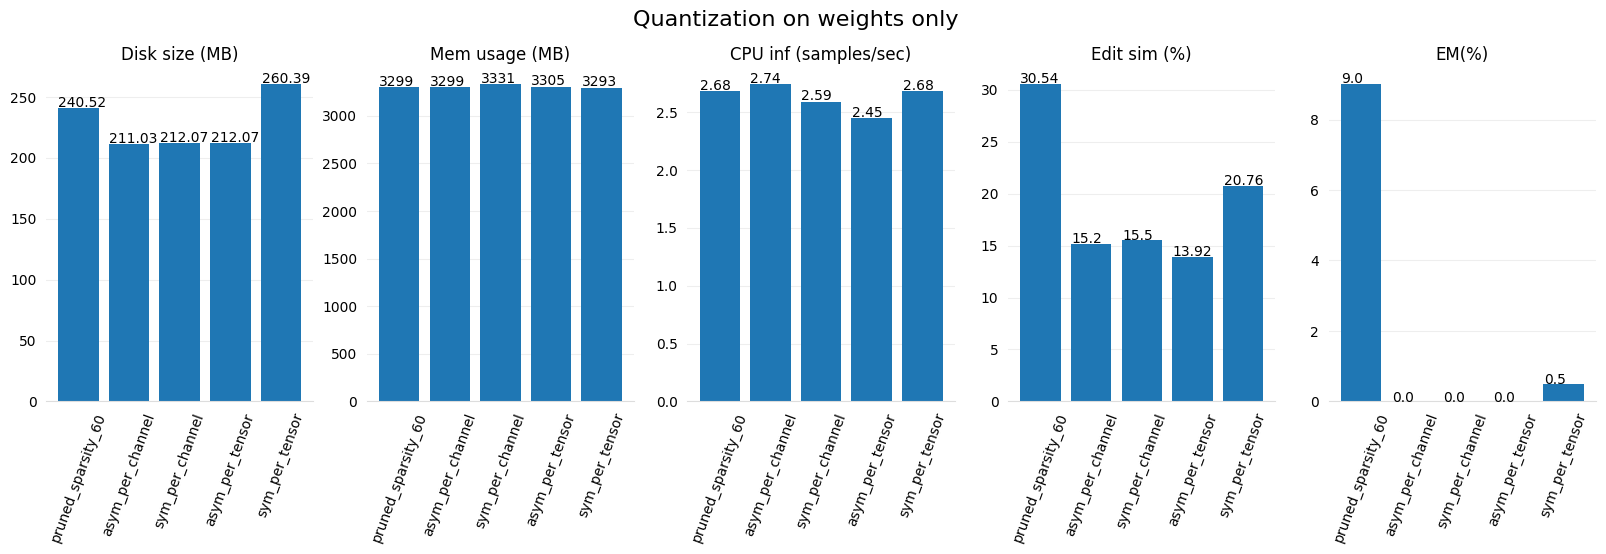

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

metrics = ['Model name', 'Disk size (MB)', 'Mem usage (MB)', 'CPU inf (samples/sec)', 'Edit sim (%)', 'EM(%)']

results_pruning = pd.read_csv('./results/pruning.csv')
results_pruning.columns = metrics

fig, ax = plt.subplots(1, 5, figsize=(20, 4.5))
for i, metric in enumerate(metrics[1:]):
    ax[i].bar(results_pruning['Model name'], results_pruning[metric])

    # Text annotations to the top of the bars
    for p in ax[i].patches:
        if metric == metrics[2]:
            # If the subplot is "Memory usage" round the value to the nearest integer, so we don't have overlapping text
            ax[i].annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))
        else:
            ax[i].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    ax[i].set_title(metric)

    # Remove the top, right and left figure borders
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_color('#DDDDDD')  # Make the bottom spine gray
    ax[i].tick_params(bottom=False, left=False)  # Remove ticks

    # Light gray horizontal grid lines
    ax[i].set_axisbelow(True)
    ax[i].yaxis.grid(True, color='#EEEEEE')
    ax[i].xaxis.grid(False)  # Hide the vertical gridlines
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)
fig.subplots_adjust(top=0.85)
plt.suptitle("Pruning", fontsize=16)
plt.show()

results_quant_all_layers = pd.read_csv('./results/quant_all_layers.csv')
results_quant_all_layers.columns = metrics

fig, ax = plt.subplots(1, 5, figsize=(20, 4.5))
for i, metric in enumerate(metrics[1:]):
    ax[i].bar(results_quant_all_layers['Model name'], results_quant_all_layers[metric])

    # Text annotations to the top of the bars
    for p in ax[i].patches:
        if metric == metrics[2]:
            # If the subplot is "Memory usage" round the value to the nearest integer, so we don't have overlapping text
            ax[i].annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))
        else:
            ax[i].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    ax[i].set_title(metric)

    # Remove the top, right and left figure borders
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_color('#DDDDDD')  # Make the bottom spine gray
    ax[i].tick_params(bottom=False, left=False)  # Remove ticks

    # Light gray horizontal grid lines
    ax[i].set_axisbelow(True)
    ax[i].yaxis.grid(True, color='#EEEEEE')
    ax[i].xaxis.grid(False)  # Hide the vertical gridlines
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)
fig.subplots_adjust(top=0.85)
fig.suptitle('Quantization on all layers', fontsize=16)
plt.show()

results_quant_only_weights = pd.read_csv('./results/quant_only_weights.csv')
results_quant_only_weights.columns = ['Model name', 'Disk size (MB)', 'Mem usage (MB)', 'CPU inf (samples/sec)', 'Edit sim (%)', 'EM(%)']

fig, ax = plt.subplots(1, 5, figsize=(20, 4.5))
for i, metric in enumerate(metrics[1:]):
    # ax[i].bar(results.keys(), [results[key][metric] for key in results.keys()])
    ax[i].bar(results_quant_only_weights['Model name'], results_quant_only_weights[metric])

    # Text annotations to the top of the bars
    for p in ax[i].patches:
        if metric == metrics[2]:
            # If the subplot is "Memory usage" round the value to the nearest integer, so we don't have overlapping text
            ax[i].annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))
        else:
            ax[i].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    ax[i].set_title(metric)

    # Remove the top, right and left figure borders
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_color('#DDDDDD')  # Make the bottom spine gray
    ax[i].tick_params(bottom=False, left=False)  # Remove ticks

    # Light gray horizontal grid lines
    ax[i].set_axisbelow(True)
    ax[i].yaxis.grid(True, color='#EEEEEE')
    ax[i].xaxis.grid(False)  # Hide the vertical gridlines

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)
fig.subplots_adjust(top=0.85)
fig.suptitle('Quantization on weights only', fontsize=16)
plt.show()

### Count the number of parameters in the 60% sparse model:

In [2]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained('AISE-TUDelft/BRP-Sochirca-CodeGPT-Py150-pruned-0.6-sparsity')


def count_nonzero_parameters(model):
    """
    Count the number of non-zero parameters (weights) in a model
    """
    return sum(p.nonzero().size(0) for p in model.parameters() if p.requires_grad)


print("Number of parameters in the 60% sparse model: " + str(count_nonzero_parameters(model)))

Number of parameters in the 60% sparse model: 49770059


### Examine ONNX inference:

In [1]:
import shutil
import gc
import os
import time

import pandas as pd
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from intel_extension_for_transformers.optimization.pipeline import pipeline
from pandarallel import pandarallel
from tqdm import tqdm
from optimum.onnxruntime import ORTModelForCausalLM

pandarallel.initialize(progress_bar=True, nb_workers=1)
tqdm.pandas()

from fuzzywuzzy import fuzz
import re
from memory_profiler import memory_usage

# Load tokenizer and dataset
tokenizer = AutoTokenizer.from_pretrained("microsoft/CodeGPT-small-py", truncation_side='left')
dataset = load_dataset("0n1xus/codexglue", 'code-completion-token-py150')
test = dataset['test'].to_pandas()


# We split the input code snippet and take the last line as the expected output and the rest as input
def split_input_output(x):
    split_seq = x['code'].split('<EOL>')
    return ['<EOL>'.join(split_seq[0:-1]) + '<EOL>', split_seq[-1]]


test[['input', 'output']] = test.progress_apply(split_input_output, axis=1, result_type="expand")
test = test.sample(1000, random_state=42)  # Sample 1000 examples for evaluation


def eval_model(model, model_name, path):
    """
    Evaluate the model on the test set
    :param model: The model to evaluate
    :param model_name: The name of the model (for output purposes)
    :param path: The path to the (zipped) model dir, to measure the disk size
    :return: A dictionary with the evaluation results
    """
    # Create a pipeline to generate with the model
    generator = pipeline('text-generation',  # Type of pipeline
                         tokenizer="microsoft/CodeGPT-small-py",
                         model=model,
                         framework="pt",
                         device=torch.device('cpu'), )

    def generate(sample):
        """
        Get the model's output for a given input
        """
        output_tokens = tokenizer(sample['output'], truncation=True, max_length=1024)
        num_tokens = 1024 - (len(output_tokens) + 2)
        truncated_input = tokenizer.decode(tokenizer.encode(sample['input'])[-num_tokens:])
        return generator(truncated_input, max_new_tokens=len(output_tokens))[0]['generated_text']

    def apply_function():
        """
        Run generation and measure memory usage. We need to run it sequentially, otherwise the memory usage will impact the inference speed.
        """
        test['gen_output'] = test.progress_apply(generate, axis=1)

    mem_usage = memory_usage(apply_function)

    def post_process(code):
        """
        Post-process the model's output to remove the special tokens
        Shamelessly stolen from: https://github.com/microsoft/CodeXGLUE/blob/main/Code-Code/CodeCompletion-line/evaluator/evaluator.py
        """
        code = code.replace("<NUM_LIT>", "0").replace("<STR_LIT>", "").replace("<CHAR_LIT>", "")
        pattern = re.compile(r"<(STR|NUM|CHAR)_LIT:(.*?)>", re.S)
        lits = re.findall(pattern, code)
        for lit in lits:
            code = code.replace(f"<{lit[0]}_LIT:{lit[1]}>", lit[1])
        return code

    def score(batch):
        """
        Compute the edit similarity and exact match between the model's output and the expected output
        """
        pred = post_process(batch['gen_output'].strip().replace('<s>', '').split('<EOL>')[-1])
        gt = post_process(batch['output'].strip().replace('</s>', ''))
        edit_sim = fuzz.ratio(pred, gt)
        EM = 0
        if pred.split() == gt.split():
            EM = 1
        return edit_sim, EM

    # Measure the disk size of the model directory in MB
    disk_size = os.path.getsize(path) * 1.04858 / 1024 / 1024

    # ES & EM
    test[['edit_sim', 'EM']] = test.progress_apply(score, axis=1, result_type="expand")

    def inference_time(sample):
        """
        Measure the inference time for one sample
        """
        start_time = time.time()
        generate(sample)
        end_time = time.time()
        return end_time - start_time

    # Average CPU inference
    num_samples = len(test)
    cpu_inference = num_samples / test.progress_apply(inference_time, axis=1).sum()

    return {
        'Model name': model_name,
        'Disk size': disk_size,
        'Mem usage': max(mem_usage),
        'CPU inf': cpu_inference,
        'Edit sim': sum(list(test['edit_sim'])) / len(test),
        'EM': sum(list(test['EM'])) / len(test) * 100
    }


def get_eval_results(model_names, model_paths):
    """
    Evaluate all models in model_paths and return the results in a dataframe
    """
    results = []
    for name, path in zip(model_names, model_paths):
        gc.collect()  # Free up memory

        if name == 'onnx inference':
            # If the model is an ONNX model, we need to load it with the ORTModelForCausalLM class
            model = ORTModelForCausalLM.from_pretrained(path, export=True)

            # Save the model to the ./models directory, so we can zip it
            path = "./models/" + path.replace('AISE-TUDelft/', '') + "_onnx"
            model.save_pretrained(path)

            # Delete the decoder_with_past_model to reduce space
            # The directory has 2 models: decoder_with_past_model.onnx and decoder_model.onnx, which amount to double the size we want to measure
            # We only need to measure the size of the decoder_model, so we can delete the other one
            del_path = path + '/decoder_with_past_model.onnx'
            os.remove(del_path)

        else:
            # If the model is a huggingface model, we need to load it with the AutoModelForCausalLM class
            model = AutoModelForCausalLM.from_pretrained(path)

            # Save the model to the ./models directory, so we can zip it
            path = "./models/" + path.replace('AISE-TUDelft/', '')
            model.save_pretrained(path)

        # Zip the model directory
        shutil.make_archive(path.replace('models', 'models_zipped'), 'zip', path)
        path = path.replace('models', 'models_zipped') + '.zip'

        results.append(eval_model(model, name, path))

        # Free up memory
        del model

    results = pd.DataFrame(results)
    results = results[['Model name', 'Disk size', 'Mem usage', 'CPU inf', 'Edit sim', 'EM']].round(2)
    return results


model_paths = ['AISE-TUDelft/CodeGPT-Py150',
               'AISE-TUDelft/BRP-Sochirca-CodeGPT-Py150-pruned-0.6-sparsity',
               'AISE-TUDelft/BRP-Sochirca-CodeGPT-Py150-pruned-0.6-sparsity']
names = ['original', 'compressed', 'onnx inference']

eval_results = get_eval_results(names, model_paths)

eval_results

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Found cached dataset codexglue (C:/Users/ddani/.cache/huggingface/datasets/0n1xus___codexglue/code-completion-token-py150/1.0.1/cbc1754b04b259211f238bbcad21909b788b5c2c10a60ee52429a8b4be0ffbbe)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:01<00:00, 34746.38it/s]
Function transformers.pipelines.base.infer_framework_load_model is replaced by intel_extension_for_transformers.optimization.pipeline.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
100%|██████████| 1000/1000 [20:55<00:00,  1.26s/it]
Function transformers.pipelines.base.infer_framework_load_model is replaced by intel_extension_for_transformers.optimization.pipeline.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1000/1000 [20:50<00:00,  1.25s/it]
Framework not specified. Using pt to export to ONNX.
use_past = False is different than use_present_in_outputs = True, the value of use_present_in_outputs val

============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Using framework PyTorch: 2.0.1+cpu
Overriding 1 configuration item(s)
	- use_cache -> True
Asked a sequence length of 16, but a sequence length of 1 will be used with use_past == True for `input_ids`.


============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Asked a sequence length of 16, but a sequence length of 1 will be used with use_past == True for `input_ids`.
Function transformers.pipelines.base.infer_framework_load_model is replaced by intel_extension_for_transformers.optimization.pipeline.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1000/1000 [10:29<00:00,  1.59it/s]


,Model name,Disk size,Mem usage,CPU inf,Edit sim,EM
0,original,462.26,2184.49,0.80,39.05,14.5
1,compressed,240.52,2189.63,0.80,30.54,9.0
2,onnx inference,311.75,4166.37,1.59,30.54,9.0
